In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split, SubsetRandomSampler, Subset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt
import random

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [18]:
root = './data'

In [19]:
dataset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transforms.ToTensor())


Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [20]:
batchSize = 50

trainset, validateset = random_split(dataset, [45000, 5000])

trainset_indices = random.sample(range(len(trainset)), k=2000)
trainset_subset = Subset(trainset, trainset_indices)


validateset_indices = random.sample(range(len(validateset)), k=200)
validateset_subset = Subset(validateset, validateset_indices)

In [21]:
train = DataLoader(trainset_subset, batchSize, shuffle=True, num_workers=4, pin_memory=True)
validate = DataLoader(validateset_subset, batchSize, shuffle=True, num_workers=4, pin_memory=True)


classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Model 1

In [22]:
class Cifar10Classifier1(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(
            
            # here we define 3 channels as our inpur, 32 channels as the output, 
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch, device):
        # unpack the images and labels from the
        images, labels = batch
        
        images=images.to(device)
        labels = labels.to(device)

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch, device):
        images, labels = batch
        
        images=images.to(device)
        
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

In [28]:
class Cifar10Classifier2(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(
            
            # here we define 3 channels as our inpur, 32 channels as the output, 
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),
            
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            # nn.ReLU(),
            # # apply a max pool layer
            # nn.MaxPool2d(2, 2),


            # continue the process in the next two layers
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),

            #nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(16384, 2048),
        
            nn.ReLU(),
            nn.Linear(2048, 10)
        )

    def trainingStep(self, batch, device):
        # unpack the images and labels from the
        images, labels = batch
        
        images=images.to(device)
        labels = labels.to(device)

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch, device):
        images, labels = batch
        
        images=images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

In [4]:
torch.cuda.is_available()

False

In [25]:
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch, device) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [26]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optimizationFunction(model.parameters(), lr)
   
    for epoch in range(epochs):
        #print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            
            loss = model.trainingStep(batch, device)
            trainingLosses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")

In [27]:
# instantiate the model
model1 = Cifar10Classifier1()

# do an evaluation of the model on the tra
evaluateModel(model1, validate)

# instantiate the model
model2 = Cifar10Classifier2()

# do an evaluation of the model on the tra
evaluateModel(model2, validate)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x16384 and 4096x2048)

In [120]:
trainset_indices = random.sample(range(len(trainset)), k=2000)
trainset_subset = Subset(trainset, trainset_indices)
validateset_indices = random.sample(range(len(validateset)), k=200)
validateset_subset = Subset(validateset, validateset_indices)

In [121]:
#create boostrap
bootstrap_indices = random.choices(range(len(trainset_subset)), k=len(trainset_subset))
boostrap_subset = Subset(trainset_subset, bootstrap_indices)
bootstrap = DataLoader(boostrap_subset, batchSize, shuffle=True, num_workers=2, pin_memory=True)

        

In [122]:
%%time
trainModel(6, 0.001, model1, trainLoader=bootstrap, validationLoader=validate, optimizationFunction=torch.optim.Adam)

CPU times: user 2.75 s, sys: 506 ms, total: 3.26 s
Wall time: 4.16 s


In [123]:
%%time
trainModel(6, 0.001, model2, trainLoader=bootstrap, validationLoader=validate, optimizationFunction=torch.optim.Adam)

CPU times: user 2.84 s, sys: 546 ms, total: 3.38 s
Wall time: 4.71 s


In [124]:
evaluateModel(model1, validate)['loss']

1.9411215782165527

In [125]:
evaluateModel(model2, validate)['loss']

1.7877379655838013

# Test Pipeline

In [ ]:
batchSize = 25

In [126]:
!pip install deepsig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00


In [133]:
from torch.utils.data import random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu
import pandas as pd
from tqdm import tqdm
from deepsig import aso, bootstrap_test, permutation_test
from random import sample
import random
CONSIDERED_TESTS = {
    "ASO": lambda a, b: aso(a, b, show_progress=False),
    "Student's t": lambda a, b: ttest_ind(a, b, equal_var=False, alternative="greater")[
        1
    ],
    "Bootstrap": lambda a, b: bootstrap_test(a, b),
    "Permutation": lambda a, b: permutation_test(a, b),
    "Wilcoxon": lambda a, b: wilcoxon(a, b, alternative="greater").pvalue,
    "Mann-Whitney U": lambda a, b: mannwhitneyu(a, b, alternative="greater").pvalue,
    }

SAMPLE_SIZES = [5, 10, 15, 20]

In [134]:
def get_subsample(trainset, validateset):

    
    trainset_indices = random.sample(range(len(trainset)), k=2000)
    trainset_subset = Subset(trainset, trainset_indices)
    validateset_indices = random.sample(range(len(validateset)), k=200)
    validateset_subset = Subset(validateset, validateset_indices)
    

    return trainset_subset, validateset_subset

In [135]:
def bootstrap_scores(trainset_sub, validateset_sub):
    #Takes in models and data, performs 40 bootstrap samples (20 for each model)
    #Returns two lists of scores (list of list)
    scores1 = []
    batchSize = 50
    validate = DataLoader(validateset_sub, batchSize, shuffle=True, num_workers=2, pin_memory=True)

    for i in range(0,20):
        #create boostrap
        #print(f"model1 bootstrap #: {i}")
        model1 = Cifar10Classifier1()
        
        bootstrap_indices = random.choices(range(len(trainset_sub)), k=len(trainset_sub))
        boostrap_subset = Subset(trainset_sub, bootstrap_indices)
        bootstrap = DataLoader(boostrap_subset, batchSize, shuffle=True, num_workers=2, pin_memory=True)
       

        trainModel(6, 0.001, model1, trainLoader=bootstrap, validationLoader=validate, optimizationFunction=torch.optim.Adam)
        score = evaluateModel(model1, validate)['loss']
        scores1.append(score)
    scores2 = []
    for i in range(0,20):
        #create boostrap
        #print(f"model2 bootstrap #: {i}")
        model2 = Cifar10Classifier1()
        
        bootstrap_indices = random.choices(range(len(trainset_sub)), k=len(trainset_sub))
        boostrap_subset = Subset(trainset_sub, bootstrap_indices)
        bootstrap = DataLoader(boostrap_subset, batchSize, shuffle=True, num_workers=2, pin_memory=True)

        trainModel(6, 0.001, model2, trainLoader=bootstrap, validationLoader=validate, optimizationFunction=torch.optim.Adam)
        score = evaluateModel(model2, validate)['loss']
        scores2.append(score)
    scores = [scores1, scores2]
    return scores

In [136]:
def compute_stats(scores, stats_dict):
    #Takes in sets of scores, performs various statistical testing 
    #Output is 2d array, type of test on one axis and sample size on the other
    for samp_size in SAMPLE_SIZES:
        scores1 = sample(scores[0],samp_size)
        scores2 = sample(scores[1],samp_size)
        samp_size_scores = []
        iter = 0
        for key in CONSIDERED_TESTS:
            pval = CONSIDERED_TESTS[key](scores1, scores2)
            stats_dict[samp_size][iter].append(pval)
            iter += 1
        
    return stats_dict

In [139]:
def make_statistics(nloops):
    #full_data_X and full_data_y must be two numpy arrays
    stats_dict = {
    5: [[], [], [], [], [], []],
    10: [[], [], [], [], [], []],
    15: [[], [], [], [], [], []],
    20: [[], [], [], [], [], []]
    }
    for i in range(0,nloops):
        print(f"outer loop num: {i}")
        train, validate = get_subsample(trainset,validateset)
        scores = bootstrap_scores(train, validate)
        stats_dict = compute_stats(scores, stats_dict)
    return(stats_dict)

In [ ]:
#Test with two iterations
stats = make_statistics(100)

outer loop num: 0
outer loop num: 1
outer loop num: 2
outer loop num: 3
outer loop num: 4
outer loop num: 5
outer loop num: 6
outer loop num: 7
outer loop num: 8
outer loop num: 9
outer loop num: 10
outer loop num: 11
outer loop num: 12
outer loop num: 13
outer loop num: 14
outer loop num: 15
outer loop num: 16
outer loop num: 17
outer loop num: 18
outer loop num: 19
outer loop num: 20
outer loop num: 21
outer loop num: 22
outer loop num: 23
outer loop num: 24
outer loop num: 25
outer loop num: 26
outer loop num: 27
outer loop num: 28
outer loop num: 29
outer loop num: 30
outer loop num: 31
outer loop num: 32
outer loop num: 33
outer loop num: 34
outer loop num: 35
outer loop num: 36
outer loop num: 37
outer loop num: 38
outer loop num: 39
outer loop num: 40
outer loop num: 41
outer loop num: 42
outer loop num: 43
outer loop num: 44
outer loop num: 45
outer loop num: 46
outer loop num: 47
outer loop num: 48
outer loop num: 49
outer loop num: 50


In [ ]:
#save stats to json file
import json
with open('CNN_TYPE111.json', 'w') as fp:
    json.dump(stats, fp)


In [18]:
import json
with open('CNN_TYPE11.json', 'r') as fp:
    stats = json.load(fp)

In [26]:
#for each sample size, calculate the type 1 error rate in stats for each test
type1error_dict = {
    5: [],
    10: [],
    15: [],
    20: []
}

for key in stats.keys():
    for j in range(0, 6):
        count = 0
        for k in range(0, 100):
            if j == 0:
                if stats[key][j][k] < 0.2:
                    count += 1
            else:
                if stats[key][j][k] < 0.05:
                    count += 1
                
            
        type1error_dict[int(key)].append(count/100) 

In [27]:
#restructure data for line plotting
type1error_dict = pd.DataFrame(type1error_dict)
type1error_dict = type1error_dict.transpose()
type1error_dict.columns = ["ASO", "Student's t", "Bootstrap", "Permutation", "Wilcoxon", "Mann-Whitney U"]
type1error_dict = type1error_dict.reset_index()
type1error_dict = type1error_dict.rename(columns = {"index": "Sample Size"})
type1error_dict = type1error_dict.melt(id_vars = ["Sample Size"], var_name = "Test", value_name = "Type 1 Error Rate")


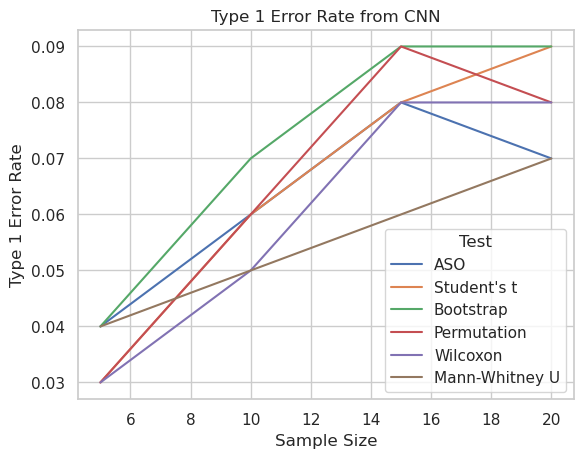

In [29]:
#plot type 1 error rate
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x="Sample Size", y="Type 1 Error Rate", hue="Test", data=type1error_dict)
ax.set_title("Type 1 Error Rate from CNN")
ax.set(xlabel='Sample Size', ylabel='Type 1 Error Rate')
plt.savefig("type1error_mixture.png")